# Forecast the CocaCola prices. Explain how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.
---

## Data Gathering

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# Loading the dataset
df = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
df

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


We have 42 records for annual quarters from first quarter of 1986 to second quarter of 1996

We need to convert Quarter column to a datatime format

In [27]:
# extract year and quarter information from the 'date_col' column
df['year'] = df['Quarter'].apply(lambda x: int('19' + x.split('_')[1]))
df['quarter_no'] = df['Quarter'].apply(lambda x: x.split('_')[0])

# convert year and quarter information into datetime format
df['date'] = pd.PeriodIndex(year=df['year'], quarter=pd.to_numeric(df['quarter_no'].str[1:]), freq='Q').to_timestamp()

# drop year and quarter columns
df = df.drop(['Quarter'], axis=1)

df.set_index('date', inplace = True)

## Data Exploration

In [28]:
# Checking for na values
df.isna().sum()

Sales         0
year          0
quarter_no    0
dtype: int64

no na values

In [29]:
# Checking for duplicates
df[df.duplicated()]

,Sales,year,quarter_no
date,,,


no duplicates

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42 entries, 1986-01-01 to 1996-04-01
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sales       42 non-null     float64
 1   year        42 non-null     int64  
 2   quarter_no  42 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ KB


We have 42 samples

In [31]:
df.describe()

,Sales,year
count,42.000000,42.000000
mean,2994.353308,1990.761905
std,977.930896,3.074756
min,1547.818996,1986.000000
25%,2159.714247,1988.000000
50%,2782.376999,1991.000000
75%,3609.250000,1993.000000
max,5253.000000,1996.000000


## Data Visualization

Text(0.5, 1.0, 'Time series of No. of Passengers')

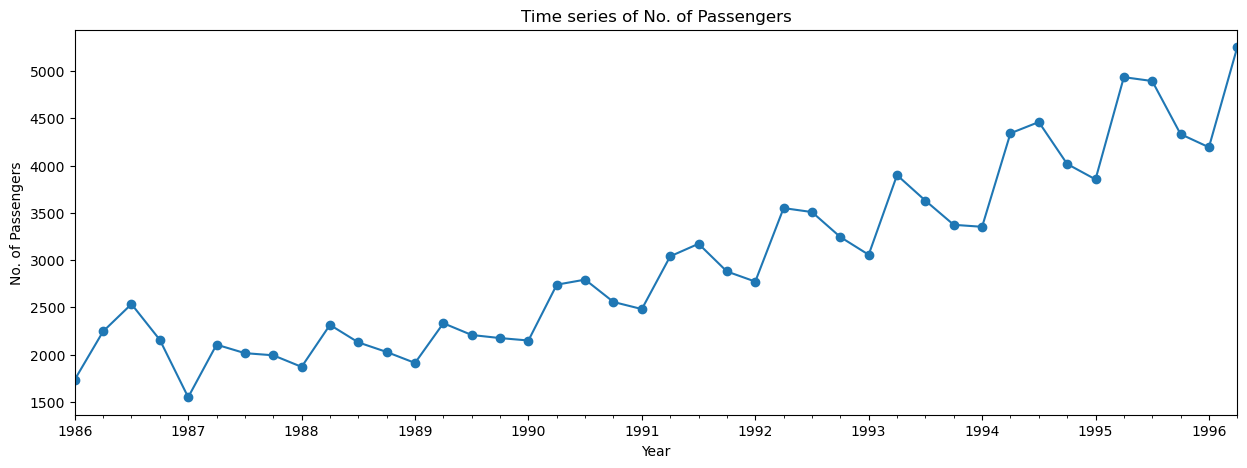

In [32]:
# Lineplot
df.Sales.plot(figsize=(15, 5), marker = 'o')
plt.xlabel('Year')
plt.ylabel('No. of Passengers')
plt.title('Time series of No. of Passengers')

We can see an upward trend and possibly seasonality as well from this plot. Hence, the data is not stationary.

<Axes: xlabel='Sales', ylabel='Count'>

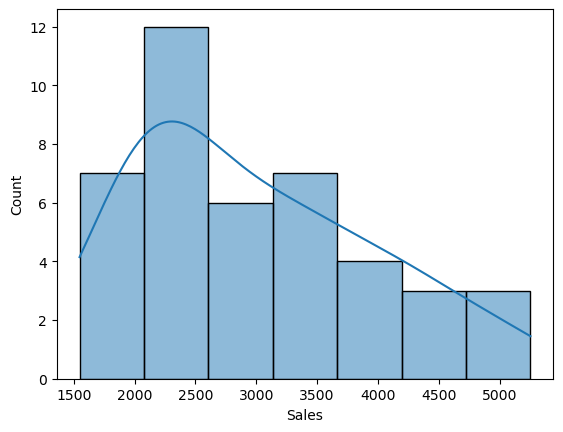

In [33]:
# Histplot with kde
sns.histplot(df, x = 'Sales', kde = True)

Series is right skewed. We will use transformations to make the series stationary.

<Axes: xlabel='quarter_no', ylabel='year'>

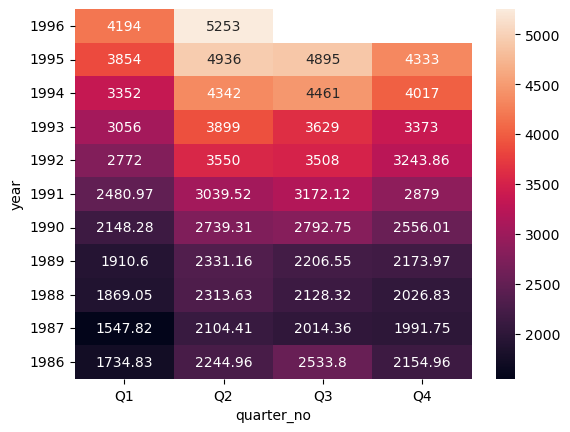

In [34]:
# Pivoting the time series to get a year by month matrix with passengers as values
Sales_every_quarter = pd.pivot_table(data=df,values="Sales",index="year",columns="quarter_no")

# Setting order of quarters
# Sales_every_quarter = passengers_every_month[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]

# Sorting by year descending
Sales_every_quarter.sort_index(ascending=False, inplace=True)

# Heatmap
sns.heatmap(Sales_every_quarter,annot=True,fmt="g")

We have higher values as each year passes, and 2nd or 3rd quarter have higher values than rest

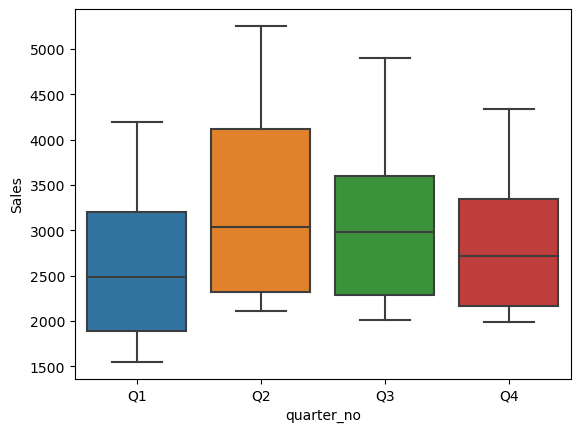

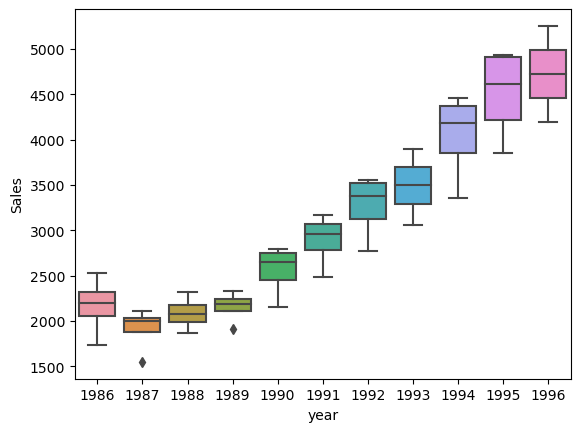

In [35]:
# Boxplots for quarter and year

sns.boxplot(df, x = 'quarter_no', y = 'Sales')
plt.show()
sns.boxplot(df, x = 'year', y = 'Sales')
plt.show()

Every year we have an upward trend in number of passengers except for the first year. We can see seasonality from boxplot for month. We have a peak at 2nd quarter and trough at 1st quarter.

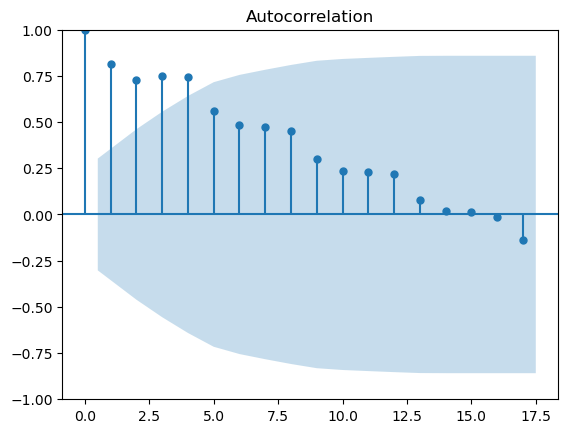

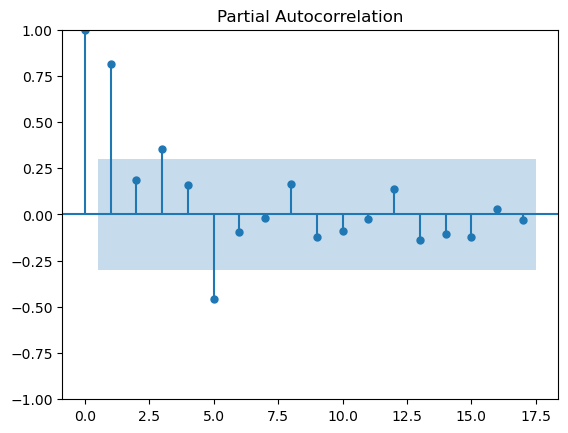

In [38]:
# Autocorrelation and Partial Autocorrelation plot

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df.Sales)
plt.show()
plot_pacf(df.Sales)
plt.show()

Lags 1, 3, and 5 have high correlation

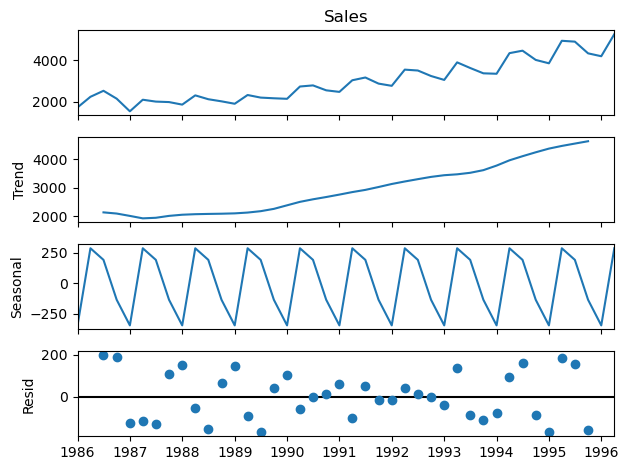

In [39]:
# Getting timeseries decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df['Sales']).plot()
plt.show()

Trend seems somewhat quadratic

## Feature Engineering

In [41]:
# Adding a timeseries index as a column
df['t'] = [i for i in range(1, df.shape[0] + 1)]

In [42]:
df['t_sqrd'] = df.t.apply(lambda x : x**2)

In [45]:
# Getting dummy columns for quarter
quarters = pd.get_dummies(df['quarter_no'])
quarters = quarters[['Q1','Q2','Q3']]
df = pd.concat([df,quarters],axis=1)

We want to make our data stationary.

In [46]:
from statsmodels.tsa.stattools import adfuller

# define function to check stationarity using ADF test and plot rolling mean and standard deviation along timeseries
def adf_test(timeseries):
    """
    Performs Augmented Dickey-Fuller test on given time series
    """
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    roll = int(dfoutput['#Lags Used'])
    rolling_mean=timeseries.rolling(roll).mean()
    rolling_std = timeseries.rolling(roll).std()
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

Results of Augmented Dickey-Fuller Test:
Test Statistic                  1.309421
p-value                         0.996661
#Lags Used                      7.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


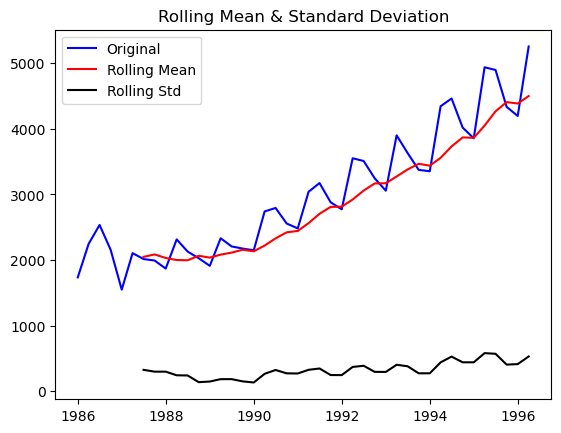

In [47]:
adf_test(df['Sales'])

Our data could havs quadratic, or exponential trend and has additive seasonality. We want a p-value of atmost 0.05 to conclude that the data is stationary.

Results of Augmented Dickey-Fuller Test:
Test Statistic                  0.828594
p-value                         0.992084
#Lags Used                      6.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


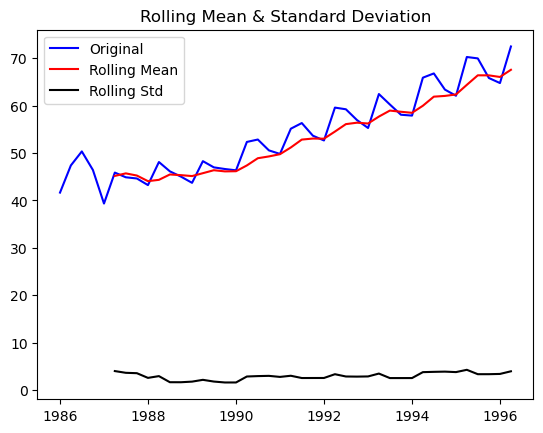

In [48]:
# Applying square root transformation
df['sqrt_Sales'] = np.sqrt(df['Sales'])
adf_test(df['sqrt_Sales'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -2.935683
p-value                         0.041353
#Lags Used                      6.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


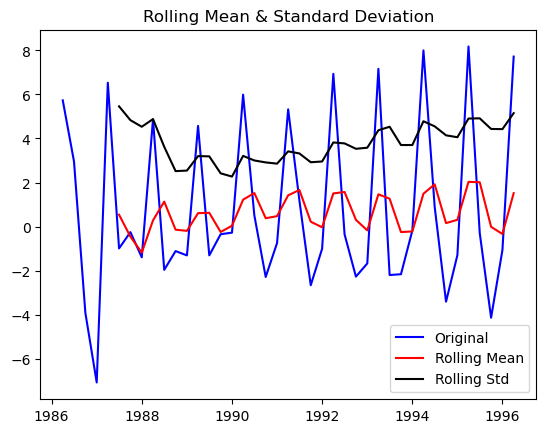

In [49]:
adf_test(df['sqrt_Sales'].diff(1).dropna())

Differencing square root of Sales, makes the data stationary

Results of Augmented Dickey-Fuller Test:
Test Statistic                  0.192820
p-value                         0.971856
#Lags Used                      6.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


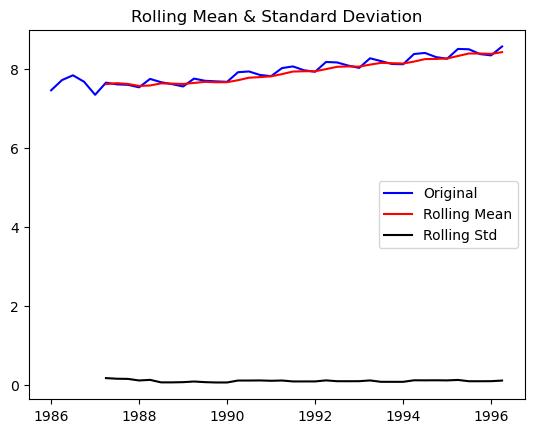

In [50]:
# Applying log transformation
df['log_Sales'] = np.log(df['Sales'])
adf_test(df['log_Sales'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -3.190392
p-value                         0.020548
#Lags Used                      6.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


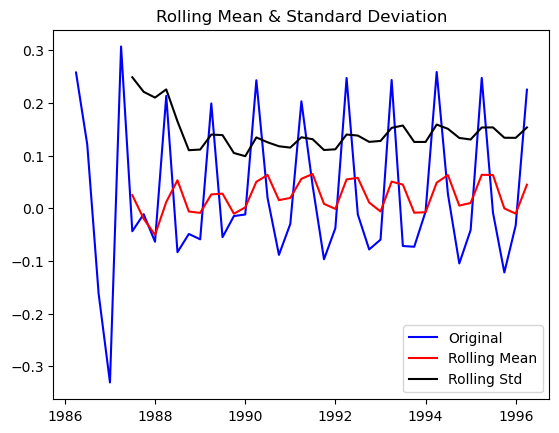

In [51]:
adf_test(df['log_Sales'].diff(1).dropna())

Differencing log of Sales gives a better p value. Hence we will use it

In [52]:
# Creating another dataframe for stationary data
df_st = df.copy()
df_st['log_diff_Sales'] = df_st['log_Sales'].diff(1)
df_st.dropna(inplace = True)

In [53]:
df.tail(15)

,Sales,year,quarter_no,t,t_sqrd,Q1,Q2,Q3,sqrt_Sales,log_Sales
date,,,,,,,,,,
1992-10-01,3243.859993,1992,Q4,28,784,0,0,0,56.954894,8.084519
1993-01-01,3056.000000,1993,Q1,29,841,1,0,0,55.281100,8.024862
1993-04-01,3899.000000,1993,Q2,30,900,0,1,0,62.441973,8.268475
1993-07-01,3629.000000,1993,Q3,31,961,0,0,1,60.241182,8.196712
1993-10-01,3373.000000,1993,Q4,32,1024,0,0,0,58.077534,8.123558
1994-01-01,3352.000000,1994,Q1,33,1089,1,0,0,57.896459,8.117312
1994-04-01,4342.000000,1994,Q2,34,1156,0,1,0,65.893854,8.376090
1994-07-01,4461.000000,1994,Q3,35,1225,0,0,1,66.790718,8.403128
1994-10-01,4017.000000,1994,Q4,36,1296,0,0,0,63.379808,8.298291


We want to start the validation set from the first quarter

In [54]:
train_df = df.head(df.shape[0] - 6)
test_df = df.tail(6)

train_df_st = df_st.head(df_st.shape[0] - 6)
test_df_st = df_st.tail(6)

In [55]:
train_df.tail(2)

,Sales,year,quarter_no,t,t_sqrd,Q1,Q2,Q3,sqrt_Sales,log_Sales
date,,,,,,,,,,
1994-07-01,4461.0,1994,Q3,35,1225,0,0,1,66.790718,8.403128
1994-10-01,4017.0,1994,Q4,36,1296,0,0,0,63.379808,8.298291


In [56]:
test_df.head(2)

,Sales,year,quarter_no,t,t_sqrd,Q1,Q2,Q3,sqrt_Sales,log_Sales
date,,,,,,,,,,
1995-01-01,3854.0,1995,Q1,37,1369,1,0,0,62.080593,8.256867
1995-04-01,4936.0,1995,Q2,38,1444,0,1,0,70.256672,8.504311


In [57]:
train_df_st.tail(2)

,Sales,year,quarter_no,t,t_sqrd,Q1,Q2,Q3,sqrt_Sales,log_Sales,log_diff_Sales
date,,,,,,,,,,,
1994-07-01,4461.0,1994,Q3,35,1225,0,0,1,66.790718,8.403128,0.027038
1994-10-01,4017.0,1994,Q4,36,1296,0,0,0,63.379808,8.298291,-0.104838


In [58]:
test_df_st.head(2)

,Sales,year,quarter_no,t,t_sqrd,Q1,Q2,Q3,sqrt_Sales,log_Sales,log_diff_Sales
date,,,,,,,,,,,
1995-01-01,3854.0,1995,Q1,37,1369,1,0,0,62.080593,8.256867,-0.041424
1995-04-01,4936.0,1995,Q2,38,1444,0,1,0,70.256672,8.504311,0.247444


We have correctly sepearated the training and testing sets

## Regression Models

In [59]:
import statsmodels.formula.api as smf

### For original data

In [60]:
model_scores = {}

In [61]:
# For linear regression
linear_model = smf.ols('Sales~t',data=train_df).fit()
pred = linear_model.predict(test_df['t']).values
true = test_df['Sales'].values
model_scores['org_df_linear_regression'] = np.sqrt(np.mean((true - pred)**2))

In [62]:
# For exponential regression
exp_model = smf.ols('log_Sales~t',data=train_df).fit()
pred = exp_model.predict(test_df['t']).values
model_scores['org_df_exponential_regression'] = np.sqrt(np.mean((true - pred)**2))

In [63]:
# For quadratic regression
quad_model = smf.ols('Sales~t+t_sqrd',data=train_df).fit()
pred = quad_model.predict(test_df.loc[:,["t", "t_sqrd"]]).values
model_scores['org_df_quadratic_regression'] = np.sqrt(np.mean((true - pred)**2))

In [64]:
# For Additive seasonality Linear
add_season_model = smf.ols('Sales~Q1+Q2+Q3',data=train_df).fit()
pred = add_season_model.predict(test_df.loc[:,['Q1','Q2','Q3']]).values
model_scores['org_df_additive_linear_regression'] = np.sqrt(np.mean((true - pred)**2))

In [65]:
#Additive Seasonality Quadratic 
add_season_quad_model = smf.ols('Sales~t+t_sqrd+Q1+Q2+Q3',data=train_df).fit()
pred = add_season_quad_model.predict(test_df.loc[:,['Q1','Q2','Q3','t','t_sqrd']]).values
model_scores['org_df_additive_quadratic_regression'] = np.sqrt(np.mean((true - pred)**2))

In [66]:
# Multiplicative Seasonality Linear
mul_season_model = smf.ols('log_Sales~Q1+Q2+Q3',data=train_df).fit()
pred = mul_season_model.predict(test_df.loc[:,['Q1','Q2','Q3']]).values
model_scores['org_df_multiplicative_linear_regression'] = np.sqrt(np.mean((true - pred)**2))

In [67]:
#Multiplicative Additive Seasonality 
mul_add_season_model = smf.ols('log_Sales~t+Q1+Q2+Q3',data=train_df).fit()
pred = mul_add_season_model.predict(test_df.loc[:,['t','Q1','Q2','Q3']]).values
model_scores['org_df_multiplicative_and_additive_linear_regression'] = np.sqrt(np.mean((true - pred)**2))

### For stationary data

In [68]:
# For linear regression
linear_model = smf.ols('log_diff_Sales~t',data=train_df_st).fit()
pred = linear_model.predict(test_df_st['t']).values
true = test_df_st['log_diff_Sales'].values
model_scores['st_df_linear_regression'] = np.sqrt(np.mean((true - pred)**2))

In [69]:
# For exponential regression
exp_model = smf.ols('log_diff_Sales~t',data=train_df_st).fit()
pred = exp_model.predict(test_df_st['t']).values
model_scores['st_df_exponential_regression'] = np.sqrt(np.mean((true - pred)**2))

In [70]:
# For quadratic regression
quad_model = smf.ols('log_diff_Sales~t+t_sqrd',data=train_df_st).fit()
pred = quad_model.predict(test_df_st.loc[:,["t", "t_sqrd"]]).values
model_scores['st_df_quadratic_regression'] = np.sqrt(np.mean((true - pred)**2))

In [71]:
# For Additive seasonality Linear
add_season_model = smf.ols('log_diff_Sales~Q1+Q2+Q3',data=train_df_st).fit()
pred = add_season_model.predict(test_df_st.loc[:,['Q1','Q2','Q3']]).values
model_scores['st_df_additive_linear_regression'] = np.sqrt(np.mean((true - pred)**2))

In [72]:
#Additive Seasonality Quadratic 
add_season_quad_model = smf.ols('log_diff_Sales~t+t_sqrd+Q1+Q2+Q3',data=train_df_st).fit()
pred = add_season_quad_model.predict(test_df_st.loc[:,['Q1','Q2','Q3','t','t_sqrd']]).values
model_scores['st_df_additive_quadratic_regression'] = np.sqrt(np.mean((true - pred)**2))

In [73]:
pd.Series(model_scores).sort_values()

st_df_additive_quadratic_regression                        0.029639
st_df_additive_linear_regression                           0.029939
st_df_quadratic_regression                                 0.140474
st_df_linear_regression                                    0.141466
st_df_exponential_regression                               0.141466
org_df_additive_quadratic_regression                     283.061961
org_df_quadratic_regression                              485.140670
org_df_linear_regression                                 667.425698
org_df_additive_linear_regression                       1895.559313
org_df_exponential_regression                           4594.886488
org_df_multiplicative_and_additive_linear_regression    4594.887974
org_df_multiplicative_linear_regression                 4595.375515
dtype: float64

We got the best score i.e. lowest rmse for additive quadratic for stationary dataset.

### Modelling on the entire stationary data

In [75]:
#Build the model on entire stationary data set for Additive Seasonality Quadratic Regression

quad_model = smf.ols('log_diff_Sales~t+t_sqrd',data=df_st).fit()
true = df_st.log_diff_Sales.values
pred = quad_model.predict(df_st.loc[:,["t", "t_sqrd"]]).values
errors = true - pred
print(f"RMSE : {np.sqrt(np.mean((errors)**2))}")

RMSE : 0.1445893079277965


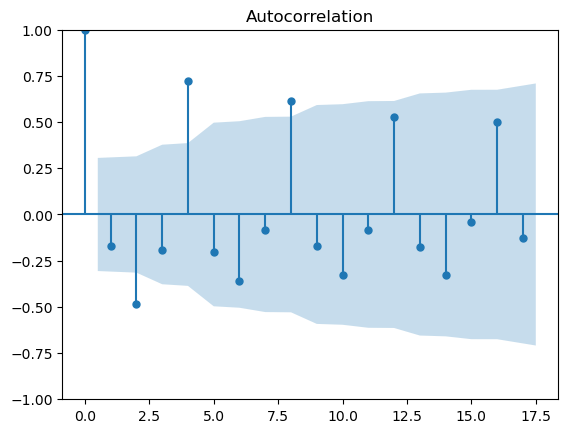

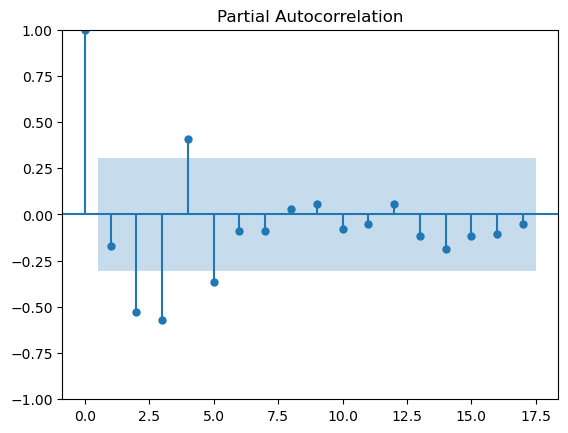

In [76]:
# Plotting ACF and PACF for the errors
plot_acf(errors)
plt.show()
plot_pacf(errors)
plt.show()

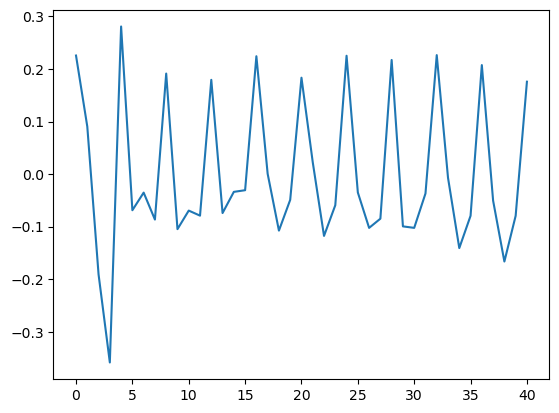

In [77]:
plt.plot(errors)

<Axes: ylabel='Count'>

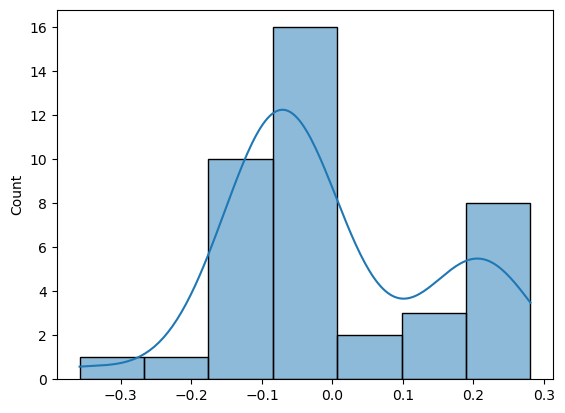

In [78]:
sns.histplot(x = errors, kde = True)

From the above error graphs, there seems to be a pattern, and thus or model is not optimal.

## Exponential Smoothing Models

In [79]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

### For original data

Original data has trend as well as seasonality. Hence, we will use Holt-Winters Exponential Smoothing

In [85]:
hwe_add_season_model = ExponentialSmoothing(train_df["Sales"],seasonal="add",trend="add",seasonal_periods=4).fit() 
true = test_df.Sales.values
pred = hwe_add_season_model.predict(start = test_df.index[0],end = test_df.index[-1])
np.sqrt(np.mean((true - pred)**2))

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


189.09126247307447

In [86]:
hwe_mul_season_model = ExponentialSmoothing(train_df["Sales"],seasonal="mul",trend="add",seasonal_periods=4).fit() 
true = test_df.Sales.values
pred = hwe_mul_season_model.predict(start = test_df.index[0],end = test_df.index[-1])
np.sqrt(np.mean((true - pred)**2))

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


71.53068826241645

### For stationary data

In [87]:
# Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(train_df_st["log_diff_Sales"]).fit()
pred = ses_model.predict(start = test_df_st.index[0],end = test_df_st.index[-1])
true = test_df_st.log_diff_Sales.values
np.sqrt(np.mean((true - pred)**2))

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


0.14244229742734427

In [88]:
# Holt’s Linear Exponential Smoothing
hles_model = Holt(train_df_st["log_diff_Sales"]).fit()
pred = hles_model.predict(start = test_df_st.index[0],end = test_df_st.index[-1])
np.sqrt(np.mean((true - pred)**2))

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


0.15106574519946037

In [91]:
# Holt-Winters Exponential Smoothing with additive seasonality
hwes_model = ExponentialSmoothing(train_df_st["log_diff_Sales"],seasonal="add",trend="add",seasonal_periods=4).fit()
pred = hwes_model.predict(start = test_df_st.index[0],end = test_df_st.index[-1])
np.sqrt(np.mean((true - pred)**2))

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


0.03337283623451805

Holt-Winters Exponential Smoothing with additive seasonality for stationary data gave the lowest rmse

### Modelling on the entire stationary data

In [93]:
#Build the Holt-Winters Exponential Smoothing model with additive seasonality on entire stationary data

hwes_model = ExponentialSmoothing(df_st["log_diff_Sales"],seasonal="add",trend="add",seasonal_periods=4).fit()
true = df_st.log_diff_Sales.values
pred = hwes_model.predict(start = df_st.index[0],end = df_st.index[-1])
errors = true - pred
print(f"RMSE : {np.sqrt(np.mean((errors)**2))}")

RMSE : 0.058869465320657774


C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


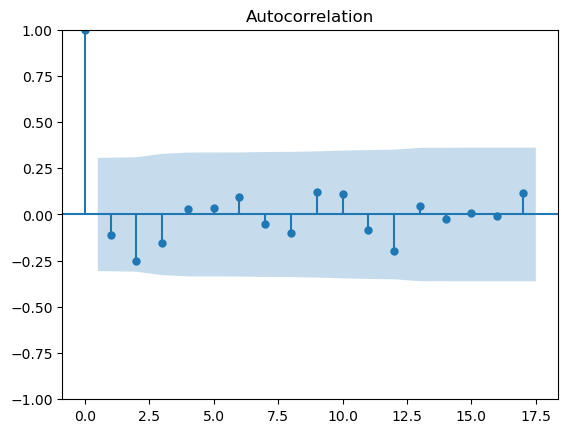

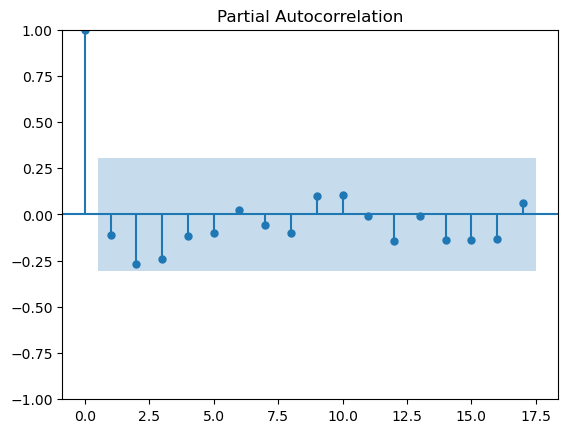

In [96]:
# Plotting ACF and PACF for the errors
plot_acf(errors)
plt.show()
plot_pacf(errors)
plt.show()

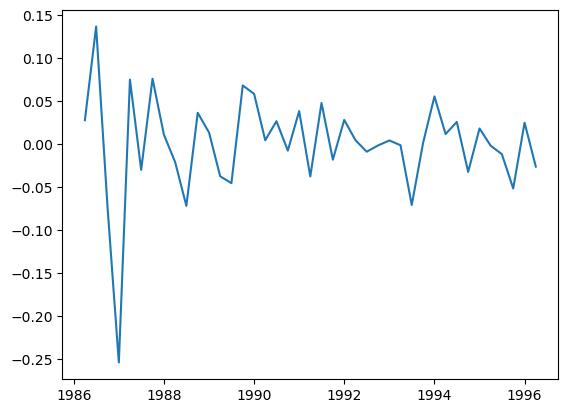

In [97]:
plt.plot(errors)

<Axes: ylabel='Count'>

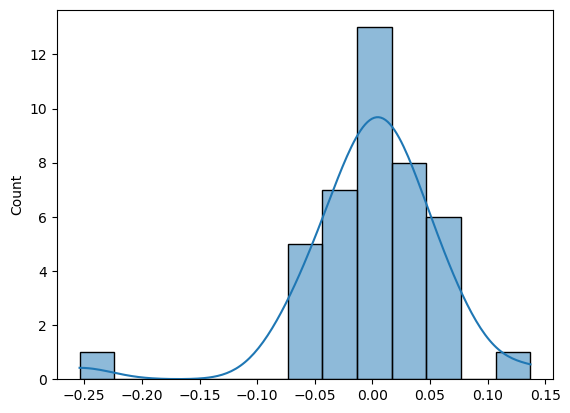

In [98]:
sns.histplot(x = errors, kde = True)

From the above error graphs, we can conclude that the errors have no pattern, and thus or model is optimal.

We got a fractionally better score than regression models

## ARIMA Model

ARIMA needs timeseries to be stationary. Hence, we will use stationary data

### Hyperparameter Tuning

In [100]:
from statsmodels.tsa.arima.model import ARIMA

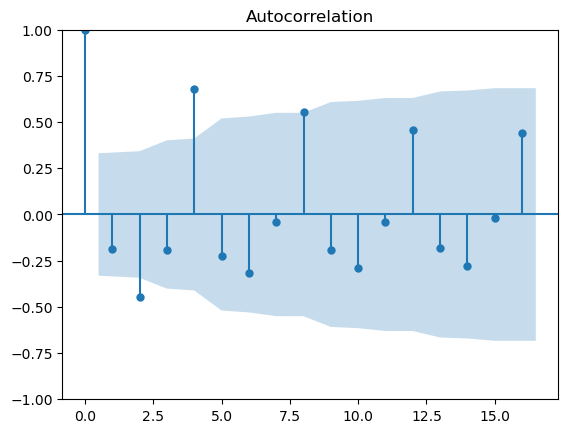

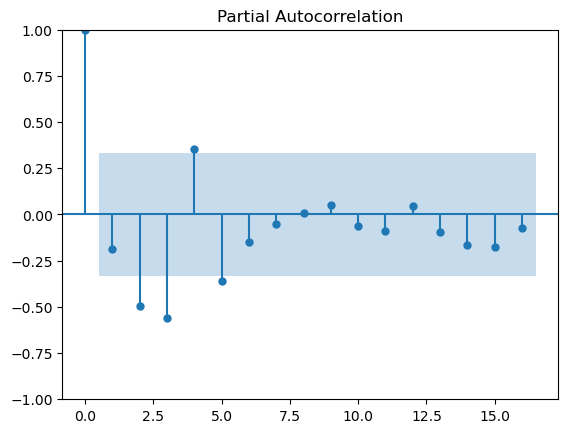

In [101]:
# Plotting ACF and PACF for the errors
plot_acf(train_df_st['log_diff_Sales'])
plt.show()
plot_pacf(train_df_st['log_diff_Sales'])
plt.show()

In [102]:
# Function to evaluate rmse for ARIMA model for passed order (p,d,q)
def evaluate_arima_model(arima_order):
    model = ARIMA(train_df_st['log_diff_Sales'], order = arima_order).fit()
    true = test_df_st.log_diff_Sales
    pred = model.forecast(steps=len(test_df_st.log_diff_Sales)).values
    return np.sqrt(np.mean((true - pred)**2))

In [103]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values):
    best_score, best_pdq = np.inf, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(order)
                    if rmse < best_score:
                        best_score, best_pdq = rmse, order
                        print(f'RMSE={rmse} for order {order}')
                except:
                    continue
    print(f'Best Score\n===========\nRMSE={best_score} for order {best_pdq}')

In [104]:
import warnings
# Defining hyperparameters
p_values = range(1, 11)
d_values = range(1, 11)
q_values = range(1, 11)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)

RMSE=0.1446335045597472 for order (1, 1, 1)
RMSE=0.12385123637723001 for order (1, 1, 2)
RMSE=0.10777947827720352 for order (1, 1, 6)
RMSE=0.07957416741304295 for order (1, 1, 8)
RMSE=0.0606393524740288 for order (1, 1, 9)
RMSE=0.03867090511826474 for order (2, 1, 6)
RMSE=0.0198025957271554 for order (3, 1, 2)
RMSE=0.01860256968185757 for order (3, 2, 3)
RMSE=0.01611442996459852 for order (8, 2, 3)
Best Score
RMSE=0.01611442996459852 for order (8, 2, 3)


### Modelling on the entire stationary data

In [105]:
#Build the ARIMA model on entire stationary data

model = ARIMA(df_st['log_diff_Sales'], order = (8, 2, 3)).fit()
true = df_st.log_diff_Sales
pred = model.forecast(steps=len(df_st.log_diff_Sales)).values
errors = true - pred
print(f"RMSE : {np.sqrt(np.mean((errors)**2))}")

RMSE : 0.20306191263167644


RMSE for validation data is much smaller than entire stationary data

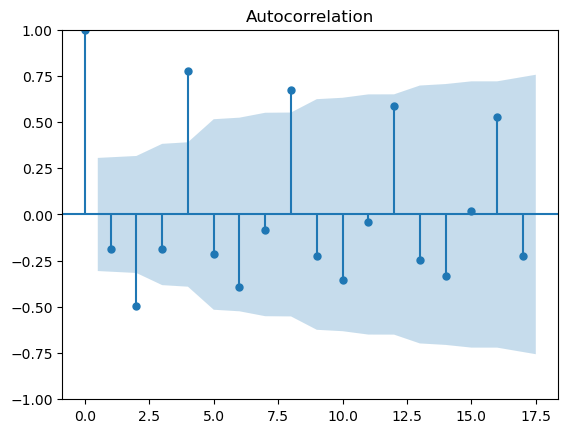

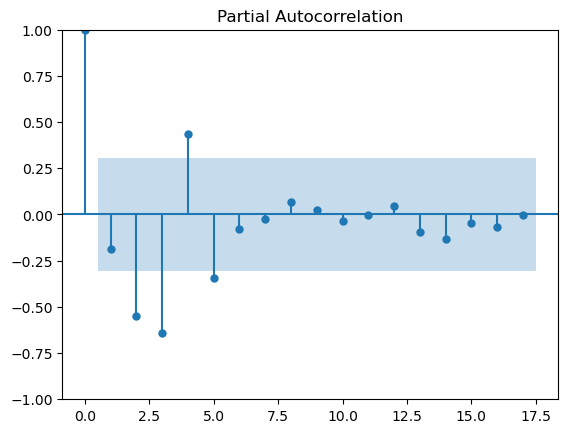

In [106]:
# Plotting ACF and PACF for the errors
plot_acf(errors)
plt.show()
plot_pacf(errors)
plt.show()

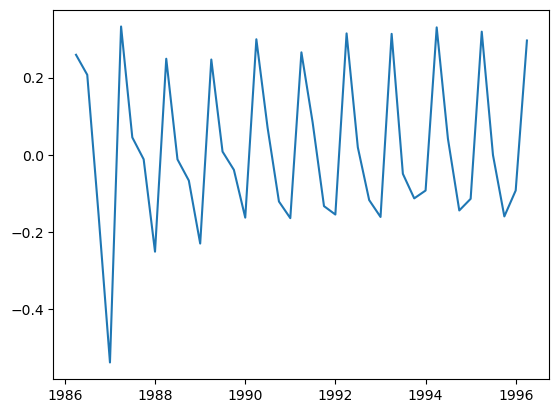

In [107]:
plt.plot(errors)

<Axes: xlabel='log_diff_Sales', ylabel='Count'>

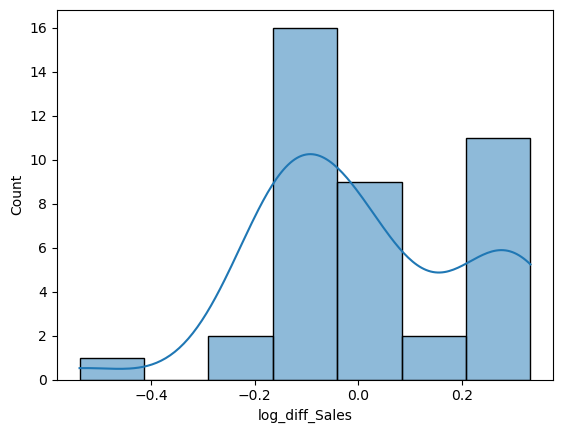

In [108]:
sns.histplot(x = errors, kde = True)

From the above error graphs, we can conclude that there exists a pattern in the errors, and thus or model is not optimal.

Let us try again for p, q used from visual inspection of ACF and PACF plots of stationary data. q should be lag number in ACF that cross error boundary, and p should be lag numbers in PACF that cross error boundary. d should be 0 as we have made our data stationary.

In [109]:
# Defining hyperparameters
p_values = [2, 3, 4, 5]
d_values = [0]
q_values = [2, 4, 8]
evaluate_models(p_values, d_values, q_values)

RMSE=0.07441763000144697 for order (2, 0, 2)
RMSE=0.05456706881314937 for order (2, 0, 8)
RMSE=0.03329089866352553 for order (3, 0, 2)
RMSE=0.01966542598284073 for order (4, 0, 2)
Best Score
RMSE=0.01966542598284073 for order (4, 0, 2)


In [110]:
#Build the ARIMA model on entire stationary data

model = ARIMA(df_st['log_diff_Sales'], order = (4, 0, 2)).fit()
true = df_st.log_diff_Sales
pred = model.forecast(steps=len(df_st.log_diff_Sales)).values
errors = true - pred
print(f"RMSE : {np.sqrt(np.mean((errors)**2))}")

RMSE : 0.2164161422387719


This gave us a slightly worse RMSE score

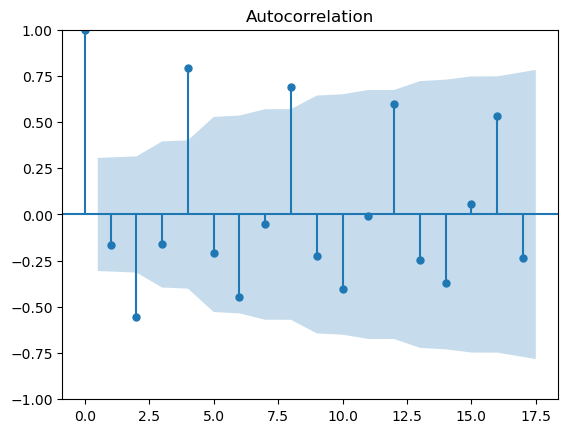

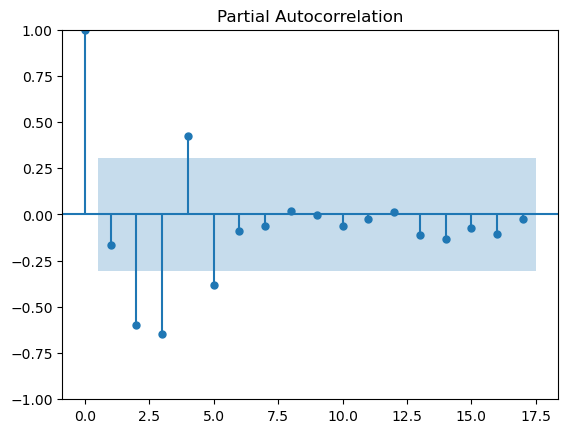

In [111]:
# Plotting ACF and PACF for the errors
plot_acf(errors)
plt.show()
plot_pacf(errors)
plt.show()

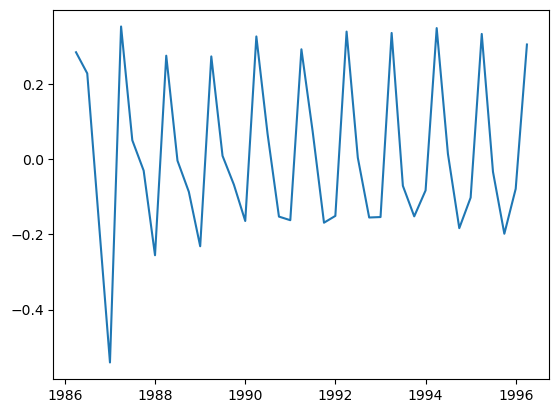

In [112]:
plt.plot(errors)

<Axes: xlabel='log_diff_Sales', ylabel='Count'>

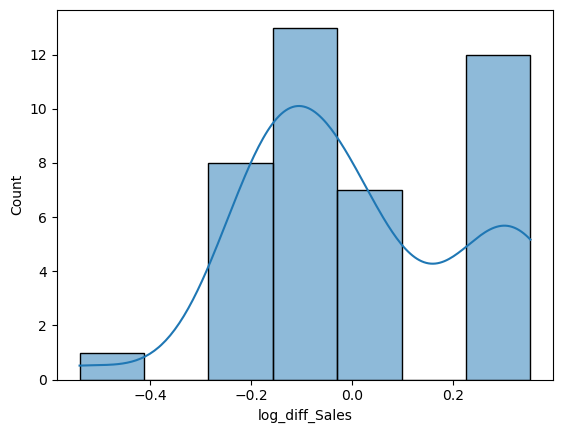

In [113]:
sns.histplot(x = errors, kde = True)

Pattern still exists. So our model is not optimal.

Our best score is not as good as other models

## Conclusion

- We got the lowest RMSE score of 0.05 for Holt-Winters Exponential Smoothing model with additive seasonality on entire stationary data
- We used log transformation and differenced it to get a stationary timeseries
- We created other dummy variables from quarters for regression models